# Class 13
## ML Models: Neural Networks

Our final topic this course will be to introduce neural networks. As before we won't go into the algorithms or how they work, but rather we will spend the time talking about their key features and when to use them. If you want more details about how they work, I recommend [this simple tutorial](http://www.kdnuggets.com/2016/10/beginners-guide-neural-networks-python-scikit-learn.html). We will be following the work of [this tutorial](http://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/) in the order and tools we use for these notes.

### Nerual Network Basics

The basic idea is that, instead of using a single Perceptron or Logistic Regression classifier, what if we used **many** of them? But we only want a single output, so maybe it makes more sense to build up an intermediate set of layers where each node of the network takes in all of the previous layer's outputs as inputs. Then, the final layer will have a single output that gives us our final prediction.

This may sound crazy, but there is a biological basis for the model: how brains work in organisms. The neurons behave in a similar fashion, thus giving rise to the name "neural" network. The key components to a neural network are the number of layers and how they are connected to each other.

### Image Recognition

We'll use the MNIST handwriting dataset for our neural network tests. We've seen this data a couple of times but previously we only used a smaller subset of the total data. We're going to need the entire dataset this time. To save disk space, I've used the python pickle package and the gzip package to store it in a compressed form.

Also, we'll have to use a couple of other new tools today: the neural network packages we have access to on SageMath don't work well with Pandas dataframes. So we'll do some of the work today using numpy tools.

We've already split the data into training/testing subgroups and stored it that way in the file. We'll load in the file and set up our features and labels.

In [1]:
import numpy as np
# fix random seed for reproducibility
np.random.seed(23)

# load data
def load_data(path='Class13_mnist.pkl.gz'):
    import gzip
    from six.moves import cPickle
    import sys
    #path = get_file(path, origin='https://s3.amazonaws.com/img-datasets/mnist.pkl.gz')

    if path.endswith('.gz'):
        f = gzip.open(path, 'rb')
    else:
        f = open(path, 'rb')

    if sys.version_info < (3,):
        data = cPickle.load(f)
    else:
        data = cPickle.load(f, encoding='bytes')

    f.close()
    return data  # (X_train, y_train), (X_test, y_test)

(features_train, labels_train), (features_test, labels_test) = load_data('Class13_mnist.pkl.gz')

print('Training Features:')
print(features_train.shape)
print('Training Labels:')
print(labels_train.shape)
print('Testing Features:')
print(features_test.shape)
print('Testing Labels:')
print(labels_test.shape)

Training Features:
(60000, 28, 28)
Training Labels:
(60000,)
Testing Features:
(10000, 28, 28)
Testing Labels:
(10000,)


So we now have 60,000 training images and 10,000 test images. Each image is $28 \times 28$ pixels and has an output label indicating what number is supposed to have been drawn.

We'll take a quick look at the data to make sure it makes sense. Visualizing is usually our best option.

Expected Digit: 1
Max value in image: 255


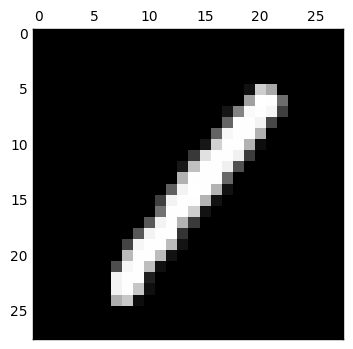

In [2]:
import matplotlib.pyplot as plt
testnum = 45076
testimage = features_train[testnum]
print('Expected Digit: {0:d}'.format(labels_train[testnum]))
print('Max value in image: {}'.format(testimage.max()))
plt.gray() 
plt.matshow(testimage) 

The neural network will work much better if we normalize the inputs. It looks like the image values run from 0 to 255. Let's re-scale that to 0-1. We change the type to a float32 since the keras tool uses that internally.

We'll also get the number of pixels in each image- we'll need that later. Finally we need to add in another dimension - this sounds weird, but it required for the neural network to use the image data. This is pretty typical of working with image learning using neural networks. This dimension represents the number of color channels in the image. For example, our gray-scale images have (1,28,28). A full-color RGB image would have the dimensions (3,28,28).


In [3]:
# normalize inputs from 0-255 to 0-1
features_train_set = features_train.astype('float32') / 255
features_test_set = features_test.astype('float32') / 255
pixdim1, pixdim2 = features_train_set.shape[1], features_train_set.shape[2]
num_pixels = pixdim1*pixdim2

features_train_set = features_train_set.reshape(features_train_set.shape[0], 1, pixdim1, pixdim2)
features_test_set = features_test_set.reshape(features_test_set.shape[0], 1, pixdim1, pixdim2)

In [4]:
features_train_set.shape

(60000, 1, 28, 28)

Finally, we need to shift our output predictions to a dummy variable since we are looking for a categorical output. Whether this step is necessary is dependent on the specific neural network tool you are using: some don't require this, others do. Because the Keras tool we will be using requires that classification models be set up this way, we'll do it. There is a Keras tool to make this easy. We'll also get the number of classes in the output test dataset.

In [5]:
from keras import backend as K
K.set_image_dim_ordering('th')
from keras.utils import np_utils

# one hot encode outputs
labels_train_cat = np_utils.to_categorical(labels_train)
labels_test_cat = np_utils.to_categorical(labels_test)
num_classes = labels_test_cat.shape[1]

Using TensorFlow backend.


## Simple One-Layer Network

We're now ready to build our first neural network. This typically requires a couple of steps:

1. Design the neural network's layers
2. Train the network

The specific code you use to design the layers depends on the neural network tool you are using. The basic types of layers are the same for all of the tools, though. In this case we will do the following.

In [6]:
# One Dense Layer model
#-------------------------------------------------------------------------------
def simpleModel():
    
    from keras.layers.core import Activation, Dense
    from keras.models import Sequential
    
    
    # create model and tell the tool that each layer we define will be added in sequential order
    model = Sequential()
       
    # our first layer is called a "Dense" layer - it is a fully connected set of nodes (every input connects to every node)
    # We tell it what shape to expect the input: in this case it is the total number of input pixels.
    # The output dimension is the number of nodes to create for this layer. We want one node for each pixel, so we use the number of pixels as our output dimension
    model.add(Dense(input_dim=num_pixels, output_dim=num_pixels, init='normal'))
    
    # The next thing we need to do is tell the network how to adjust the probabilities that the nodes compute. We'll use the hyperbolic tangent:
    # It is like the logistic regression, but on the scale of -1 to 1 instead of 0 to 1.
    model.add(Activation('tanh'))
    # Finally we need to create out output layer. In this tool we need to specify an output dimension the same as the number of classes we are trying to predict
    model.add(Dense(output_dim=num_classes, activation='softmax'))
    # This time, the softmax activation is the same as the logistic regression, but generalized for more than 2 output choices (we have 10 classes here)
    #model.add(Activation('softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

The last thing we need to do is to flatten out our input arrays. This simple neural network works better if we are only working with a single dimension of data.

Then we are ready now to train our model. We'll do a couple of things all at the same time: first we'll give the `fit()` function the test data for validation. It will use that data at every step to figure out how it is doing in terms of it's fit.

We'll also set up a couple of other parameters:
* Number of Epochs: how many times should we repeat the network training, learning from each previous iteration
* How large should we make our batches: how many images do we pile on at one time while training - typically about 1/100 of the total samples works well (as a general rule of thumb).

In [7]:
# flatten 28*28 images to a 784 vector for each image
X_train = features_train.reshape(features_train_set.shape[0], num_pixels)
X_test = features_test.reshape(features_test_set.shape[0], num_pixels)

# build the model
model = simpleModel()
# Fit the model
model.fit(X_train, labels_train_cat, validation_data=(X_test, labels_test_cat), nb_epoch=2, batch_size=600, verbose=1)
# Final evaluation of the model
scores = model.evaluate(X_test, labels_test_cat, verbose=0)
print("Baseline Accuracy {:.2f}%".format(scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 16s - loss: 0.4903 - acc: 0.8512 - val_loss: 0.2815 - val_acc: 0.9184
Epoch 2/2
60000/60000 [==============================] - 16s - loss: 0.2599 - acc: 0.9239 - val_loss: 0.2341 - val_acc: 0.9299
Baseline Accuracy 92.99%


So we're above 90% accuracy after only 2 epochs. Try increasing the number of epochs to see if there is a point where this levels out.

Let's look at the confusion matrix to see if there are any particularly problematic numbers.

In [8]:
actuals = labels_test
predictions = model.predict_classes(X_test)

 9920/10000 [============================>.] - ETA: 0s

Accuracy Score: 0.9299


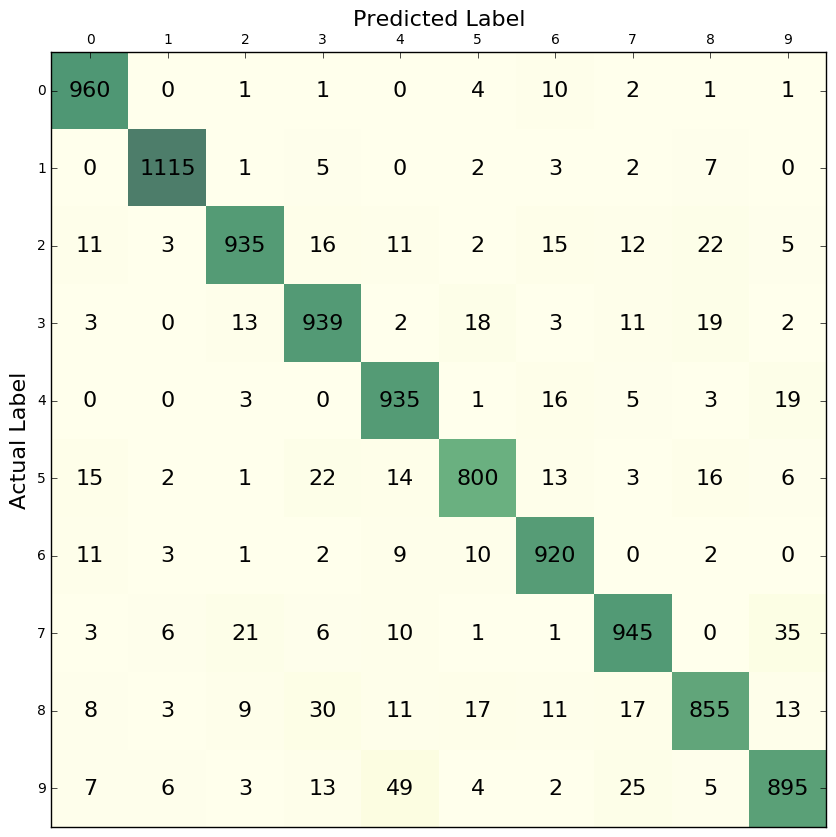

In [9]:
import sklearn.metrics as metrics

cnf_matrix = metrics.confusion_matrix(actuals, predictions)

def show_confusion_matrix(cnf_matrix, class_labels):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.matshow(cnf_matrix,cmap=plt.cm.YlGn,alpha=0.7)
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks(range(0,len(class_labels)))
    ax.set_xticklabels(class_labels)
    ax.set_ylabel('Actual Label', fontsize=16, rotation=90)
    ax.set_yticks(range(0,len(class_labels)))
    ax.set_yticklabels(class_labels)
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()

    for row in range(len(cnf_matrix)):
        for col in range(len(cnf_matrix[row])):
            ax.text(col, row, cnf_matrix[row][col], va='center', ha='center', fontsize=16)
        
show_confusion_matrix(cnf_matrix,class_labels=range(10))
score = metrics.accuracy_score(actuals, predictions)
print("Accuracy Score: {}".format(score))

### Convolution Neural Networks

One of the things about image recognition is that there is often a lot of information about the image hiding in its edges, shapes, and patterns. If we only look at the image pixels, we miss using these other types of information. A simple way to train a model using more information is to use a trick called *convolution*. This essentially gives the model additional features to look at. We build a new neural network using both fully connected layers as well as convolution layers. 

A lot of work has been done by researchers to find sets of neural network layers that work well for different types of images. The following set works fairly well for the handwriting images or other simple images with patterns.

In [10]:
# Simplified LeNet model
#-------------------------------------------------------------------------------
def leNet_model(pixdim1, pixdim2):
    
    from keras.layers.core import Activation, Dense
    from keras.models import Sequential
    
    from keras.layers.convolutional import Convolution2D, MaxPooling2D
    from keras.layers import Dropout, Flatten
    
    # create model
    model = Sequential()
    model.add(Convolution2D(20, 5, 5, border_mode='valid', input_shape=(1, pixdim1, pixdim2)))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(50, 3, 3))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    
    model.add(Dense(500))
    model.add(Activation('tanh'))
    model.add(Dense(40))
    
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [11]:
# build the model
model = leNet_model(pixdim1,pixdim2)
# Fit the model
model.fit(features_train_set, labels_train_cat, validation_data=(features_test_set, labels_test_cat), nb_epoch=2, batch_size=600, verbose=1)
# Final evaluation of the model
scores = model.evaluate(features_test_set, labels_test_cat, verbose=0)
print("Baseline Accuracy {:.2f}%".format(scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 509s - loss: 0.3385 - acc: 0.9021 - val_loss: 0.0886 - val_acc: 0.9718
Epoch 2/2
60000/60000 [==============================] - 462s - loss: 0.0780 - acc: 0.9772 - val_loss: 0.0593 - val_acc: 0.9810
Baseline Accuracy 98.10%


Even though this model takes significantly longer, it performs better than our simple single-layer model. This is even more the case when the images are more complicated than identifying handwritten digits.

# Assignment

Your assignment this week is to finish up your final project. I will collect a draft of you project via Canvas, due at the start of the final class period. I will split up the class period into blocks to spend with each student going over their project.